In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import collections
import sklearn
import pickle

Загрузка датасета

In [2]:
data = pd.read_csv('heart.csv')
data["Sex"] = [0 if i == "M" else 1 for i in data["Sex"]]
data["ChestPainType"] = [0 if i == "TA" else 1 if i == "ATA" else 2 if i == "NAP" else 3 for i in data["ChestPainType"]]
data["RestingECG"] = [0 if i == "Normal" else 1 if i == "ST" else 2 for i in data["RestingECG"]]
data["ExerciseAngina"] = [0 if i == "N" else 1 for i in data["ExerciseAngina"]]
data["ST_Slope"] = [0 if i == "Down" else 1 if i == "Flat" else 2 for i in data["ST_Slope"]]

In [3]:
a = data[(data['Cholesterol'] != 0) & (data['HeartDisease'] == 1)]['Cholesterol'].mean()
b = data[(data['Cholesterol'] != 0) & (data['HeartDisease'] == 0)]['Cholesterol'].mean()


for i in range(data.shape[0]):
    if data['Cholesterol'][i] == 0 and data['HeartDisease'][i] == 1:
        data.at[i, 'Cholesterol'] = a
    if data['Cholesterol'][i] == 0 and data['HeartDisease'][i] == 0:
        data.at[i, 'Cholesterol'] = b

In [4]:
data.drop_duplicates(keep='last')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,1,140,289.0,0,0,172,0,0.0,2,0
1,49,1,2,160,180.0,0,0,156,0,1.0,1,1
2,37,0,1,130,283.0,0,1,98,0,0.0,2,0
3,48,1,3,138,214.0,0,0,108,1,1.5,1,1
4,54,0,2,150,195.0,0,0,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,0,110,264.0,0,0,132,0,1.2,1,1
914,68,0,3,144,193.0,1,0,141,0,3.4,1,1
915,57,0,3,130,131.0,0,0,115,1,1.2,1,1
916,57,1,1,130,236.0,0,2,174,0,0.0,1,1


In [5]:
from sklearn.model_selection import train_test_split
x = data.drop(columns='HeartDisease')
y = data['HeartDisease']
x_train, x_test, train_labels, test_labels = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.2, random_state = 14)

Дерево решений

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin


class DecisionTree(BaseEstimator, ClassifierMixin):
    
    def entropy(self, x):
        return np.sum(-x * np.log2(x + (np.abs(x) < 1e-12)))
    
    def __init__(self, leaf_size = 1, depth = 4, features = None):
        self.leaf_size = leaf_size
        self.depth = depth
        self.features = features
    
    class Node:
        def __init__(self):
            self.left = None
            self.right = None
            self.value = None
            self.number = None
        
    def fit(self, data, labels):
        self.root = self.Node()
        self.grow_tree(self.root, data, labels, np.arange(len(labels)), 0)
        return self
    
    #Считаем вероятность единички
    def ans(self, y):
        k = 0
        
        for i in range(len(y)):
            if y[i] == 1:
                k += 1
        return k / len(y)
        
    
    def grow_tree(self, node, data, labels, idx, depth):
        
        x = data[idx]
        y = labels[idx]
        
        if (not self.depth is None) and (self.depth < depth):            
            node.value = self.ans(y)
            return
        
        if self.leaf_size >= len(x):
            node.value = self.ans(y)
            return
        
        if (len(np.unique(y)) == 1):
            node.value = self.ans(y)
            return
        
        maximum = -1
        split_id = 0
        leftidx = np.array([])
        rightidx = np.array([])
        index = 0
        
        for i in (self.features if self.features is not None else range(data.shape[1])):
            left = 1
            sortid = x[:, i].argsort()
            left_classes = np.zeros(2)
            left_classes[y[sortid[0]]] = 1
            
            classes = np.zeros(2)
            for j in range(len(sortid)):
                classes[y[sortid[j]]] += 1
            
            xm = self.entropy(classes / len(x))
            
            lenxm = len(sortid)
            
            right_classes = np.zeros(2)
            
            for j in range(left, len(sortid)):
                right_classes[y[sortid[j]]] += 1
            
            while left < len(x):
                
                while left < len(x) and abs(x[sortid[left-1]][i] - x[sortid[left-2]][i]) < 1e-6:
                    left += 1
                    left_classes[y[sortid[left - 1]]] += 1
                    right_classes[y[sortid[left - 1]]] -= 1
                
                if left == len(x):
                    break
                
                p = left_classes / left
                xl = self.entropy(p)
                p = right_classes / (len(x) - left)
                xr = self.entropy(p)
                
                lenxl = left
                lenxr = len(x) - left
                
                
                if maximum < xm * lenxm - lenxl * xl - lenxr * xr:
                    maximum = xm * lenxm - lenxl * xl - lenxr * xr
                    split_id = left - 1
                    leftidx = sortid[0:left]
                    rightidx = sortid[left:]
                    index = i
                
                left += 1
                
                left_classes[y[sortid[left - 1]]] += 1
                right_classes[y[sortid[left - 1]]] -= 1   
                
                
        if len(leftidx) == 0 or  len(rightidx) == 0:
            node.value = self.ans(y)
            return
        
        node.number = index
        node.value = x[sortid[split_id]][index]
        node.left = self.Node()
        node.right = self.Node()
        
        self.grow_tree(node.left, x, y, leftidx , depth + 1)
        self.grow_tree(node.right, x, y, rightidx , depth + 1)
        

    def print_tree(node, d = 0):
        if node is None:
            return
        print(' '*4*d, node.number, node.value)
        print_tree(node.left, d+1)
        print_tree(node.right, d+1)
    
    def predict_proba(self, data):
        res = np.ndarray((data.shape[0], 2))
        for i, st in enumerate(data):
            node = self.root
            while not node.number is None:
                if st[node.number] > node.value:
                    node = node.right
                else:
                    node = node.left
            res[i][1] = node.value
            res[i][0] = 1 - node.value
        return res
    
    def predict(self, data):
        return np.argmax(self.predict_proba(data), axis=1)

In [7]:
def Print_scores(test_labels, x_test_predict):
    print(f"Accuracy tests: {accuracy_score(test_labels, x_test_predict)}")
    matrix = confusion_matrix(test_labels, x_test_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
    disp.plot()
    plt.show()
    print(f"Precision tests: {precision_score(test_labels, x_test_predict)}")
    print(f"Recall tests: {recall_score(test_labels, x_test_predict)}")
    RocCurveDisplay.from_predictions(test_labels, x_test_predict)
    plt.show()

{'depth': 10, 'leaf_size': 8}
Accuracy train: 0.6104650079209766
Accuracy tests: 0.717391304347826


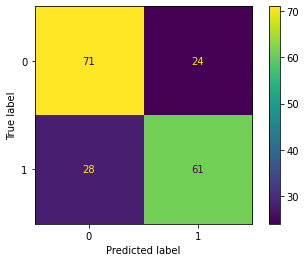

Precision tests: 0.7176470588235294
Recall tests: 0.6853932584269663


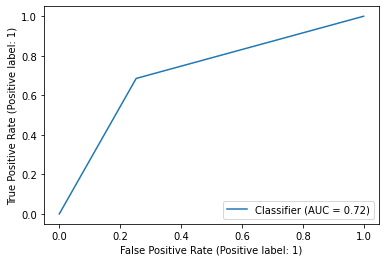

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV

test1 = [1, 4, 8, 15]
test2 = [10, 20, 60, None]
    
dt = DecisionTree()

gcv = GridSearchCV(estimator = dt, param_grid={'leaf_size': test1, 'depth': test2})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [14]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

{'max_depth': None, 'min_samples_leaf': 9}
Accuracy train: 0.8432858074736744
Accuracy tests: 0.7663043478260869


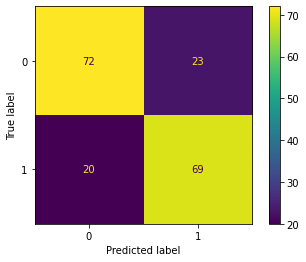

Precision tests: 0.75
Recall tests: 0.7752808988764045


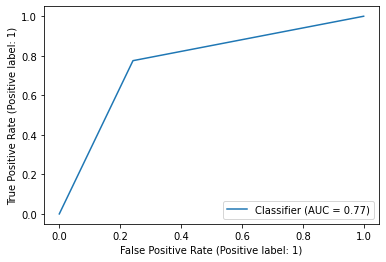

In [16]:
gcv = GridSearchCV(estimator = clf, param_grid={'min_samples_leaf': test1, 'max_depth': test2})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [9]:
class RandomForest(BaseEstimator, ClassifierMixin):
    
    def __init__(self, features = 1, leaf_size = 1, depth = None, n_estimators = 10):
        self.leaf_size = leaf_size
        self.depth = depth
        self.features = features
        self.n_estimators = n_estimators
    
    def fit(self, data, labels):
        features = np.arange(data.shape[1])
        self.estimators = []
        indexes = np.arange(len(data))
        for i in range(self.n_estimators):
            np.random.shuffle(features)
            self.estimators.append(DecisionTree(leaf_size = self.leaf_size, depth = self.depth, features = features[:self.features]))
            idx = np.random.choice(indexes, (len(data),))
            self.estimators[-1].fit(data[idx], labels[idx])
        
    def predict_proba(self, data):
        pred = np.stack([est.predict_proba(data) for est in self.estimators], axis=1)
        return pred.mean(axis=1)
    
    def predict(self, data):
        return self.predict_proba(data).argmax(axis=1)
    

{'depth': None, 'features': 3, 'leaf_size': 9, 'n_estimators': 30}
Accuracy train: 0.7737675892274718
Accuracy tests: 0.7119565217391305


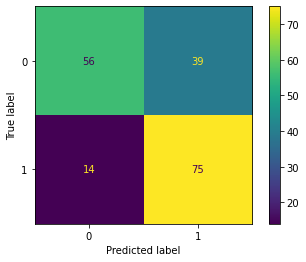

Precision tests: 0.6578947368421053
Recall tests: 0.8426966292134831


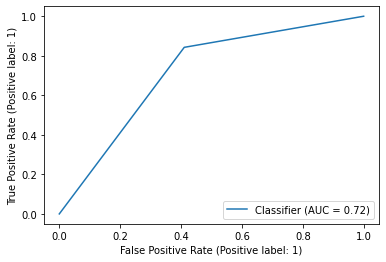

In [49]:
test1 = [3, 9]
test2 = [None]
test3 = [3]
test4 = [10, 20, 30]

rf = RandomForest()

gcv = GridSearchCV(estimator = rf, param_grid={'leaf_size': test1, 'depth': test2, 'features' : test3, 'n_estimators' : test4})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

{'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 30}
Accuracy train: 0.8678501537601342
Accuracy tests: 0.8315217391304348


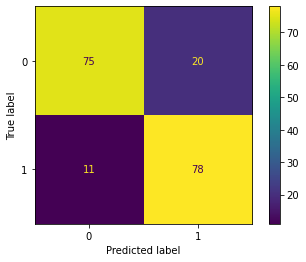

Precision tests: 0.7959183673469388
Recall tests: 0.8764044943820225


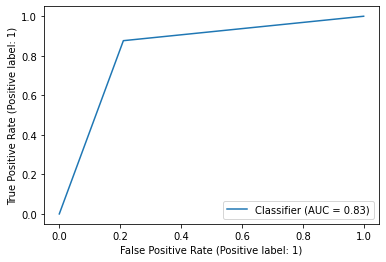

In [12]:
test1 = [3, 9]
test2 = [None]
test4 = [10, 20, 30]

gcv = GridSearchCV(estimator = rf, param_grid={'min_samples_leaf': test1, 'max_features': test2, 'n_estimators' : test4})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

{'learning_rate': 0.1, 'n_estimators': 50}
Accuracy train: 0.882816140154692
Accuracy tests: 0.8315217391304348


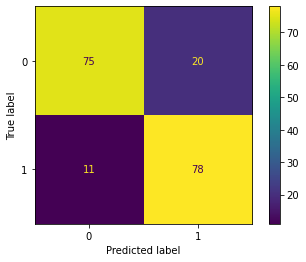

Precision tests: 0.7959183673469388
Recall tests: 0.8764044943820225


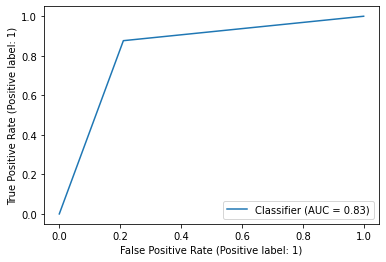

In [58]:
test1 = [0.1, 0.01, 0.001]
test2 = [10, 50, 100, 200]


gcv = GridSearchCV(estimator = gb, param_grid={'learning_rate': test1, 'n_estimators': test2})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
x_test_predict = gcv.best_estimator_.predict(x_test)
Print_scores(test_labels, x_test_predict)